Importa as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import datetime
import math
import chart_studio.plotly as py
from pathlib import Path
import plotly.graph_objects as go
import plotly.figure_factory as ff
import statistics
from plotly.subplots import make_subplots

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())

DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"
DIR_PCA = DIRETORIO_PRINCIPAL / "PCA"

DIR_MODIFICADO = DIRETORIO_DATASET / "dataset_modificado"
#DIR_QUANTITATIVOS = DIRETORIO_PRINCIPAL / "quantitativos"
#DIR_ESTATISTICAS = DIRETORIO_PRINCIPAL / "estatisticas"
#DIRETORIO_PRINCIPAL = Path(r"D:\Projeto_PA" / "Projeto_PA_validado")



In [2]:

#biblioteca do kmeans
from sklearn.cluster import KMeans

#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt

#countar os itens de uma lista
from collections import Counter

#separar treino, teste, validação
from sklearn.model_selection import train_test_split

# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math


from IPython.display import Image
from pathlib import Path

Carrega a base de dados e exibe os 5 primeiros pacientes

In [3]:

df = pd.read_csv(DIR_MODIFICADO / "pacientes_completos_tratados.csv", sep=";", encoding="Latin1")

df.head()

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,sist 9:00,sist 9:15,...,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,Diferença % Dipping
0,4,1923-10-05,1,94.0,85.0,160,33.2,2018-09-10 12:25:23,105.0,108.0,...,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34,0.966110
1,5,1948-10-07,1,70.0,80.0,165,29.4,2018-12-26 07:39:41,103.0,114.0,...,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23,0.969464
2,6,1999-03-23,1,19.0,100.0,197,25.8,2018-12-26 08:06:19,147.0,148.0,...,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19,1.055812
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2018-12-26 08:19:06,140.0,139.0,...,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9,1.106757
4,8,1990-03-07,1,28.0,120.0,172,40.6,2018-12-26 08:26:59,113.0,110.0,...,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11,1.136996


In [4]:
medidas = df.loc[:,'sist 9:00':'diast 8:45']
medidas_array = np.array(medidas)

In [5]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [6]:
### PCA

medidas_array_escala = StandardScaler().fit_transform(medidas_array)
#pca = PCA(n_components = 0.38, svd_solver = 'full')
pca = PCA(n_components = 0.95, svd_solver = 'full')

componentesPrincipais = pca.fit_transform(medidas_array_escala)

# Cria um dataframe contendo as componentes principais calculadas
dadosComponentesPrincipais = pd.DataFrame(data = componentesPrincipais, 
                                          columns = [f'principal component {i+1}' for i in range(len(componentesPrincipais[0]))])





In [7]:
dadosComponentesPrincipais

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 97,principal component 98,principal component 99,principal component 100,principal component 101,principal component 102,principal component 103,principal component 104,principal component 105,principal component 106
0,-9.710424,5.073895,3.714615,5.497793,-0.134585,-1.238458,-2.313913,-0.282622,0.287479,-5.020575,...,-0.282512,-0.427702,-0.100293,-1.009633,-0.128029,0.411911,0.229080,-0.005602,0.341338,0.693152
1,-13.300258,1.743068,-3.348576,0.626850,2.504267,0.147651,0.007327,-1.119684,-0.684642,1.336647,...,-0.050367,0.554706,0.072000,-0.448473,0.169313,-0.736884,-0.156112,-0.247546,-0.648534,-0.299701
2,2.720230,3.902192,0.796392,0.683226,0.067198,-1.700564,5.992854,2.006013,0.592652,-1.220881,...,0.384681,-0.389753,0.596723,-0.078279,-0.153859,1.073479,-0.414283,-0.335939,0.278486,-0.911563
3,4.466785,2.409507,0.169615,-1.750943,-2.636899,-1.623574,0.537230,2.132800,0.274864,-0.936007,...,0.294365,0.557213,-0.054823,-0.409427,-0.493605,0.253577,1.783070,-0.198599,0.701461,1.025478
4,-4.261159,-3.814632,1.508991,0.638462,0.284699,1.093287,2.243077,-1.260545,0.078854,0.448814,...,-0.038630,-0.705348,-0.041475,0.340021,0.829501,-0.071755,-0.406680,0.728386,-0.503075,-0.058718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,28.212872,-6.247167,-2.405576,-1.946676,0.773802,2.563166,-0.507333,-0.400047,-0.586686,-2.519601,...,-0.127672,-1.149091,-0.266728,-0.457956,-1.025978,1.406369,1.500282,0.714302,-0.194965,-0.031124
19146,8.025366,1.130140,0.751831,1.756251,-0.883906,-2.341764,2.250984,-2.630276,-0.038243,-1.748094,...,0.004672,-0.161306,-0.099203,0.304051,0.387822,-0.571841,0.551988,1.100336,-0.205157,0.192072
19147,-10.791005,3.292292,3.115896,1.916964,-0.331934,-2.126773,-0.734962,0.017982,-0.675261,-1.860339,...,1.116436,-0.063172,-0.128788,-0.780785,-0.153957,-0.190421,0.715457,0.698835,-0.477366,-0.002200
19148,-7.661591,-1.962624,2.530241,1.498214,2.371959,4.137511,2.395146,0.038754,1.438587,0.854840,...,0.381747,0.330057,-0.215510,-0.351887,-0.129212,0.696132,-0.102716,-0.249764,0.365357,-0.031768


In [8]:
print(sum(pca.explained_variance_))
print(sum(pca.explained_variance_ratio_))


155.82669640017795
0.9501131660724101


In [9]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
#  Calcula o K-means com a saída do PCA
%time sum_of_squares = calculate_wcss(componentesPrincipais)
num_otimo_clusters = optimal_number_of_clusters(sum_of_squares)
print(num_otimo_clusters)

#convertendo os dados para a clusterização
X = np.array(componentesPrincipais)

#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=num_otimo_clusters, random_state=42).fit(X)

#listar os grupos 
grupos = kmeans.fit_predict(X)
print(set(grupos))

Wall time: 1min 1s
7
{0, 1, 2, 3, 4, 5, 6}


Wall time: 0 ns


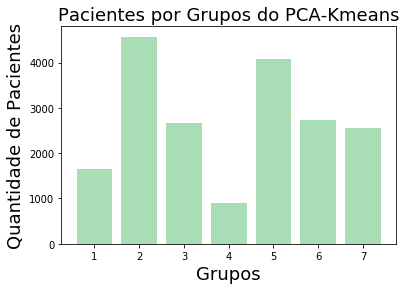

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0
Accuracy: 0.9532637075718016 - Recall: 0.926762898754756 - F1 Score: 0.9357334983320558


In [10]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
%time random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo

classes = []
qtds = []

contagem = Counter(grupos)

for i in range(num_otimo_clusters):
    classes.append(i+1)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes', fontsize=18)
plt.xlabel('Grupos', fontsize=18)
plt.title('Pacientes por Grupos do PCA-Kmeans', fontsize=18)
fig = plt.gcf()
fig.savefig(DIR_PCA / 'graficos' / 'grafico_pacientes_grupos_PCA.png',format="png")
plt.show()


train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

#treino
random_forest.fit(x_train, y_train)

#### Abordagem 1: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
#mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

#### Abordagem 1: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

In [11]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=np.array(classes)-1))
pd.DataFrame(mat,index = classes, columns = classes)

,1,2,3,4,5,6,7
1,625,16,0,2,0,11,15
2,11,1816,0,0,15,6,6
3,0,0,1057,0,22,25,0
4,33,1,0,241,0,0,54
5,0,10,18,0,1570,25,0
6,13,13,11,0,22,1017,0
7,21,6,0,2,0,0,976


In [12]:

#validacao
#pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
#pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
#pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val
#
#pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
##teste
#pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
#pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
#pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test
#
#pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
#             sep=';',index=False,encoding='UTF-8')


#### Abordagem 1: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
ls_cadastro = [f'principal component {i+1}' for i in range(len(componentesPrincipais[0]))]
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False).set_index('features')

importancia

,importance
features,
principal component 1,0.380
principal component 2,0.137
principal component 3,0.006
principal component 4,0.006
principal component 59,0.005
...,...
principal component 69,0.004
principal component 71,0.004
principal component 72,0.004


In [13]:
len(pca.components_)

106

In [14]:
lista_porcentagem = [np.round(100 * pca.components_[i], 2) for i in range(len(pca.components_))]
#lista_porcentagem.append(np.round(100 * pca.components_[0], 2))
#lista_porcentagem.append(np.round(100 * pca.components_[1], 2))
                         
nome_colunas = list(df.loc[:,'sist 9:00':'diast 8:45'].columns)
importancia_df = pd.DataFrame(lista_porcentagem,columns = nome_colunas, index =ls_cadastro )
importancia_df

,sist 9:00,sist 9:15,sist 9:30,sist 9:45,sist 10:00,sist 10:15,sist 10:30,sist 10:45,sist 11:00,sist 11:15,...,diast 6:30,diast 6:45,diast 7:00,diast 7:15,diast 7:30,diast 7:45,diast 8:00,diast 8:15,diast 8:30,diast 8:45
principal component 1,7.45,7.47,7.51,7.59,7.67,7.66,7.72,7.70,7.66,7.69,...,7.38,8.06,7.52,7.65,7.74,7.77,7.84,7.95,7.97,8.01
principal component 2,7.95,7.67,7.44,7.04,6.49,6.41,6.01,5.82,5.55,5.39,...,-2.12,-2.74,-3.02,-3.30,-3.93,-4.32,-5.17,-5.82,-6.46,-6.85
principal component 3,-1.48,-0.55,0.40,1.57,2.50,3.27,4.22,5.19,5.93,6.54,...,-16.04,-16.45,-14.23,-12.90,-11.76,-11.10,-9.98,-9.07,-8.21,-7.11
principal component 4,-11.95,-11.76,-11.61,-11.88,-11.46,-11.43,-10.90,-10.28,-9.79,-9.43,...,-6.49,-8.04,-8.35,-8.90,-9.11,-9.26,-9.34,-9.38,-9.40,-9.59
principal component 5,-10.53,-12.01,-13.00,-13.41,-13.75,-13.51,-12.92,-12.10,-11.32,-9.66,...,8.20,7.17,5.01,2.88,0.94,-1.26,-3.08,-4.68,-6.05,-7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
principal component 102,-5.17,4.71,9.49,0.86,-3.83,-9.48,-4.82,11.18,12.63,-16.06,...,-0.37,-2.28,-3.13,5.02,-0.37,8.94,-4.47,-9.32,1.66,9.32
principal component 103,-2.24,-8.34,7.95,-9.77,-5.17,19.30,-1.34,-14.37,7.84,-10.56,...,-1.14,4.28,8.21,-2.39,-2.78,-20.41,18.11,8.62,-10.10,8.79
principal component 104,7.09,15.52,-10.38,-4.35,-1.94,3.17,11.26,-4.43,-8.97,-2.73,...,-4.12,-2.84,-0.93,15.69,-10.78,5.51,-11.82,-5.75,23.94,-8.74
principal component 105,-5.61,-0.61,1.05,-1.89,6.81,-2.35,-3.08,4.40,-12.10,19.56,...,-0.29,-0.07,-0.53,-0.96,1.59,-6.59,4.18,5.24,-6.58,2.95


In [15]:
componentes_maior = [max(importancia_df.loc[f'principal component {i+1}',:]) for i in range(len(componentesPrincipais[0]))]
#componente_2_maior = max(importancia_df.loc['principal component 2',:])
componentes_maior

[8.42,
 12.92,
 12.17,
 15.7,
 14.32,
 12.42,
 12.63,
 14.49,
 14.28,
 13.32,
 14.95,
 14.52,
 14.38,
 13.01,
 13.95,
 14.38,
 16.91,
 18.16,
 17.82,
 15.73,
 15.58,
 15.1,
 17.28,
 15.62,
 14.73,
 16.39,
 17.72,
 18.45,
 15.67,
 24.19,
 17.23,
 17.5,
 15.82,
 14.8,
 17.28,
 14.9,
 16.53,
 20.64,
 17.14,
 15.51,
 18.56,
 20.92,
 16.07,
 19.93,
 16.65,
 17.98,
 20.02,
 15.33,
 15.03,
 18.16,
 17.86,
 18.38,
 21.61,
 19.97,
 17.73,
 26.82,
 22.04,
 18.4,
 16.33,
 20.13,
 18.82,
 18.33,
 21.22,
 22.35,
 20.02,
 17.08,
 17.77,
 22.79,
 15.16,
 20.8,
 24.0,
 19.45,
 20.67,
 21.75,
 20.18,
 22.56,
 18.91,
 15.72,
 15.68,
 24.38,
 16.72,
 20.37,
 23.1,
 18.55,
 22.02,
 20.97,
 20.37,
 22.28,
 29.18,
 20.88,
 21.06,
 24.89,
 23.84,
 19.31,
 23.81,
 20.32,
 20.16,
 20.69,
 23.96,
 18.47,
 17.0,
 27.69,
 23.78,
 23.94,
 24.63,
 20.58]

In [16]:
maximo = list()
#maximo2 = list()

indice = 0
for component in list(importancia_df.index):
    for coluna in list(importancia_df.columns):
        if importancia_df.loc[component ,coluna] == componentes_maior[indice]:
            maximo.append(coluna)
        #if importancia_df.loc['principal component 2',coluna] == componente_2_maior:
        #    maximo2.append(coluna)
    indice += 1

print(maximo)
#rint(maximo2)

['diast 19:00', 'sist 6:15', 'sist 14:15', 'diast 22:45', 'sist 15:15', 'sist 19:00', 'sist 8:00', 'sist 9:30', 'diast 6:30', 'sist 10:15', 'diast 6:15', 'diast 0:00', 'diast 4:00', 'sist 17:15', 'sist 12:00', 'diast 5:30', 'sist 9:00', 'sist 9:45', 'diast 9:15', 'diast 4:30', 'sist 6:45', 'sist 1:30', 'sist 1:30', 'sist 12:15', 'sist 10:45', 'sist 20:15', 'diast 13:30', 'diast 11:45', 'sist 8:30', 'diast 5:00', 'sist 12:45', 'sist 4:30', 'sist 3:00', 'diast 16:45', 'diast 12:30', 'diast 1:30', 'diast 2:00', 'diast 0:30', 'sist 2:30', 'diast 18:30', 'diast 10:45', 'sist 18:15', 'diast 7:15', 'diast 23:30', 'sist 19:30', 'diast 18:45', 'sist 18:45', 'diast 0:00', 'diast 6:30', 'sist 19:45', 'sist 12:15', 'diast 3:00', 'diast 17:15', 'diast 19:45', 'diast 6:00', 'diast 4:30', 'diast 4:30', 'diast 6:30', 'sist 12:00', 'sist 2:00', 'diast 22:00', 'diast 23:30', 'diast 11:45', 'diast 1:00', 'diast 0:00', 'diast 17:30', 'sist 16:15', 'diast 18:15', 'diast 17:00', 'diast 16:15', 'sist 23:00',

In [17]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_PCA / f"PCA_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_PCA / f"PCA_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_PCA / f"PCA_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    

In [18]:
df_apos_kmeans = df.loc[:,:'data_exame']
df_apos_kmeans['grupo'] = grupos
df_apos_kmeans['grupo'] = df_apos_kmeans['grupo'] + 1
df_apos_kmeans = pd.concat([df_apos_kmeans,df.loc[:,'sist 9:00':]],axis=1)
df_apos_kmeans

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,grupo,sist 9:00,...,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Picos Sistolica,Picos Diastolica,Diferença % Dipping
0,4,1923-10-05,1,94.0,85.0,160,33.2,2018-09-10 12:25:23,3,105.0,...,59.0,9545.5,4902.0,3748.0,841.5,16.52,11.36,11,34,0.966110
1,5,1948-10-07,1,70.0,80.0,165,29.4,2018-12-26 07:39:41,3,103.0,...,62.0,8586.5,5034.5,2915.0,606.0,7.51,6.65,9,23,0.969464
2,6,1999-03-23,1,19.0,100.0,197,25.8,2018-12-26 08:06:19,1,147.0,...,79.0,10674.0,6154.0,3721.0,751.5,12.70,13.01,19,19,1.055812
3,7,1978-01-26,0,40.0,65.0,"1,64",24.2,2018-12-26 08:19:06,1,140.0,...,80.0,10679.5,6420.5,3642.0,602.5,16.13,10.34,21,9,1.106757
4,8,1990-03-07,1,28.0,120.0,172,40.6,2018-12-26 08:26:59,5,113.0,...,78.0,9141.5,6118.0,2405.0,566.0,12.27,12.79,10,11,1.136996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19145,21786,1972-11-25,1,47.0,75.0,165,27.5,2020-09-10 16:03:08,4,163.0,...,116.0,12224.5,9265.0,2439.0,474.5,18.66,14.80,49,60,1.134475
19146,21787,1970-10-19,1,49.0,90.0,183,26.9,2020-09-10 16:21:02,7,114.0,...,85.0,10970.0,6819.0,3319.0,738.0,17.22,13.67,32,27,1.045759
19147,21788,1985-03-15,0,35.0,93.0,167,33.3,2020-09-10 16:44:53,3,107.0,...,62.0,9245.0,4935.5,3556.0,713.5,14.36,8.29,14,26,1.029243
19148,21792,1952-04-21,0,68.0,64.0,160,25.0,2020-09-10 17:25:50,5,94.0,...,68.0,8989.5,5660.0,2815.5,460.0,14.14,9.38,19,13,1.251898


In [19]:
gera_arquivos_por_grupo(df_apos_kmeans, 'medidas')